In [1]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from dataset2 import CityDataset
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net
from nn_model3 import UNet
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
import torch.nn.functional as F
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [2]:
bs = 2
# sz = (320,240)
sz = (256,256)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

In [3]:
# ds = NYUDataset('data/', tfms)
# dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

ds = CityDataset(tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

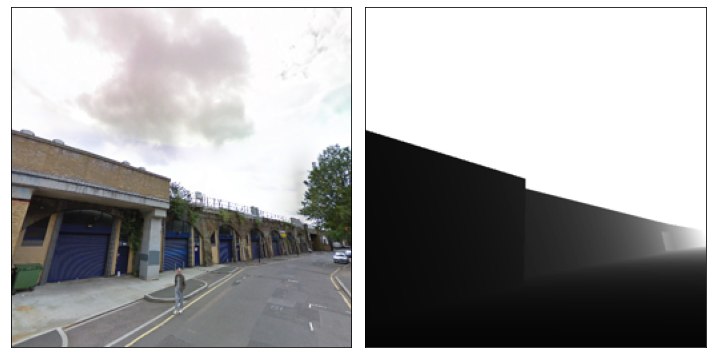

In [4]:
i = 3
plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))

#sample_batch = iter(dl).next()
#img, depth = sample_batch

In [5]:
ds[0][0].shape
# new_img_PIL = transforms.ToPILImage()(ds[0][0]).convert('RGB')
# new_img_PIL.show() 



torch.Size([3, 256, 256])

In [6]:
# model = Net()
# model.to(device)
model = UNet()
model.to(device)

UNet(
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block3_16): UNetConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_block16_32): UNetConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_block32_64): UNetConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), str

In [7]:
model.load_state_dict(torch.load('model_depth2.ckpt', map_location="cpu"))
#model_utils.freeze_all_layers(model.VGG)
#model_utils.freeze_all_layers(model.Scale_1)
#model_utils.freeze_all_layers(model.Scale_2)

<All keys matched successfully>

In [9]:
model.train()
n_epochs = 300
# lr = 0.0000005
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels ,vps ,seg_line in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = model_utils.depth_loss2(preds, labels) 
        # loss = model_utils.depth_loss2(preds, labels, vps. seg_line) 

        loss.backward()
        optimizer.step()
        
        total_steps +=1
        if e%20==10:
            torch.save(model.state_dict(),'model_depth2.ckpt')                                               
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Epoch [1/300], Iteration [1/580], Loss: 88.7953
Epoch [1/300], Iteration [10/580], Loss: 1.6127


KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(),'model_depth2.ckpt')

In [11]:
%%time
with torch.no_grad():
    model.eval()
    img, depth ,vps= iter(dl).next()
    # print(img.shape)
    preds = model(img.to(device))

CPU times: user 462 ms, sys: 0 ns, total: 462 ms
Wall time: 307 ms


[[[255. 255. 255. ...   9.   9.   9.]
  [255. 255. 255. ...   9.   9.   9.]
  [255. 255. 255. ...   9.   9.   9.]
  ...
  [  4.   4.   4. ...   4.   4.   4.]
  [  4.   4.   4. ...   4.   4.   4.]
  [  4.   4.   4. ...   4.   4.   4.]]

 [[255. 255. 255. ...  20.  20.  20.]
  [255. 255. 255. ...  20.  20.  20.]
  [255. 255. 255. ...  20.  20.  20.]
  ...
  [ 10.  10.  10. ...   9.   9.   9.]
  [ 10.  10.  10. ...   9.   9.   9.]
  [ 10.  10.  10. ...   9.   9.   9.]]]


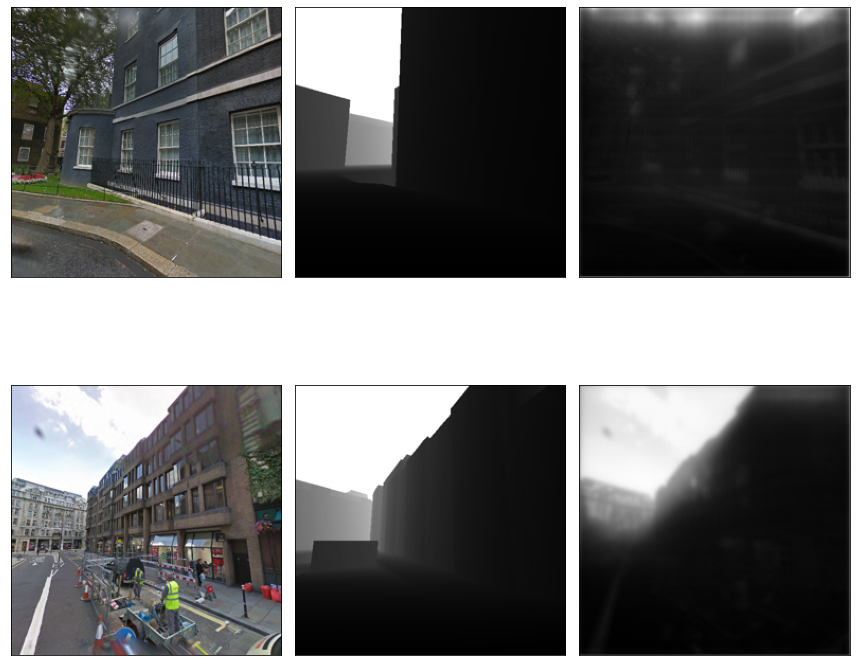

In [12]:
# print(preds.cpu()[0][0].shape)
# img2 = transforms.ToPILImage()(preds.cpu()[0][0])
# img2.show()
# print(img[0].shape)
# img3 = transforms.ToPILImage()(img[0])
# img3.show()
# print(depth[0].shape)
# img4 = transforms.ToPILImage()(depth[0])
# img4.show()
output=preds.cpu()
output = output.detach().numpy()
# out=output*0.225+0.45
# print(out*255)
plt.imsave('pred.png', np.transpose(output[0][0], (0, 1)))

output=depth
output = output.detach().numpy()
plt.imsave('GT.png', np.transpose(output[0], (0, 1)))
print(output)
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

In [20]:
test_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [22]:
import PIL
from PIL import Image

im = Image.open('test.jpg')
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

In [47]:
pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()       # -0.660375
print(pred_numpy_arr)
pred_numpy_arr = (pred_numpy_arr/pred_numpy_arr.max())*255   # max = 2.1548061, brings scale to 0-255  

pred_numpy_arr = pred_numpy_arr.astype('uint8')


[[1.7486978  1.6417919  1.6340592  ... 1.744368   1.7563572  1.8659568 ]
 [1.5527203  1.3449874  1.2539396  ... 1.4292486  1.464224   1.7102258 ]
 [1.4206573  1.1406708  1.0359955  ... 1.1908227  1.2922647  1.6235547 ]
 ...
 [0.70009196 0.20485163 0.10659719 ... 0.1552974  0.29713392 1.0085883 ]
 [0.7563809  0.25521004 0.12934709 ... 0.20684707 0.3691361  1.0690051 ]
 [1.1534944  0.7067723  0.6178715  ... 0.6445215  0.8014449  1.2387356 ]]


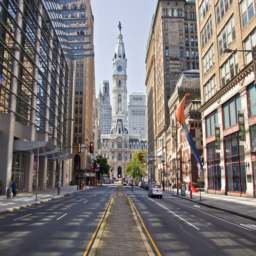

In [39]:
im.resize((256,256), resample=PIL.Image.BILINEAR)

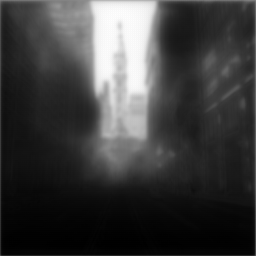

In [40]:
Image.fromarray(pred_numpy_arr, mode = 'L').resize((256, 256))

In [24]:
# T, P = transforms.ToTensor(), transforms.ToPILImage()
# dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(ds[10], unnormalize, T, P)

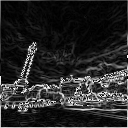

In [25]:
# P(g)

In [37]:
# from IPython.display import FileLink
# FileLink('all-scales-trained.ckpt')

/home/anxing/work/GITHUB/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network/all-scales-trained.ckpt